In [49]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
import datasets
import numpy as np
from datasets import load_dataset
import numpy as np
from annoy import AnnoyIndex
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os

In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )

In [24]:
def image_to_vec(image):
    ls = {}
    inputs = feature_extractor(image, return_tensors="pt").to(device)
    with torch.no_grad():
        hidden_states = model(**inputs, return_dict=True, output_hidden_states=True).hidden_states

        output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)
        vec = output_hidden_state.cpu().numpy()[0]
        ls['first_last_avg'] = vec

        output_hidden_state = (hidden_states[-1]).mean(dim=1)
        vec = output_hidden_state.cpu().numpy()[0]
        ls['last_avg'] = vec

        output_hidden_state = (hidden_states[-1] + hidden_states[-2]).mean(dim=1)
        vec = output_hidden_state.cpu().numpy()[0]
        ls['last2avg'] = vec

        output_hidden_state = (hidden_states[-1])[:, 0, :]
        vec = output_hidden_state.cpu().numpy()[0]
        ls['cls'] = vec

    return ls

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [21]:
# dataset = datasets.load_dataset("huggingface/cats-image")
# dataset = datasets.load_dataset("data/oxford")
# dataset = datasets.load_dataset("data/vehicle")
# image = dataset["train"]["image"][0]


# dir(model)
# x = image_to_vec(image)
# print(type(x['cls']))
# dir(feature_extractor)
# inputs = feature_extractor(image, return_tensors="pt")
# inputs.to(device)
# dataset = datasets.load_dataset("data/vehicle")
dataset = datasets.load_dataset("data/oxford")

Resolving data files:   0%|          | 0/5063 [00:00<?, ?it/s]

Using custom data configuration oxford-14af9141f9fd528e
Reusing dataset imagefolder (/home/sunxiaodong/.cache/huggingface/datasets/imagefolder/oxford-14af9141f9fd528e/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
types = ['first_last_avg', 'last_avg', 'last2avg', 'cls']
features = dict()
for t in types:
    features[t] = dict()

for image in dataset['train']['image']:
    filename = image.filename.split('/')[-1]
    d = image_to_vec(image)
    
    for t in types:
        features[t][filename] = d[t]

In [23]:
# features['first_last_avg']['000_0001.png'].shape
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [26]:
with open('oxford_features.pkl', 'rb') as f:
    oxford_features = pickle.load(f)
with open('vehicle_features.pkl', 'rb') as f:
    vehicle_features = pickle.load(f)

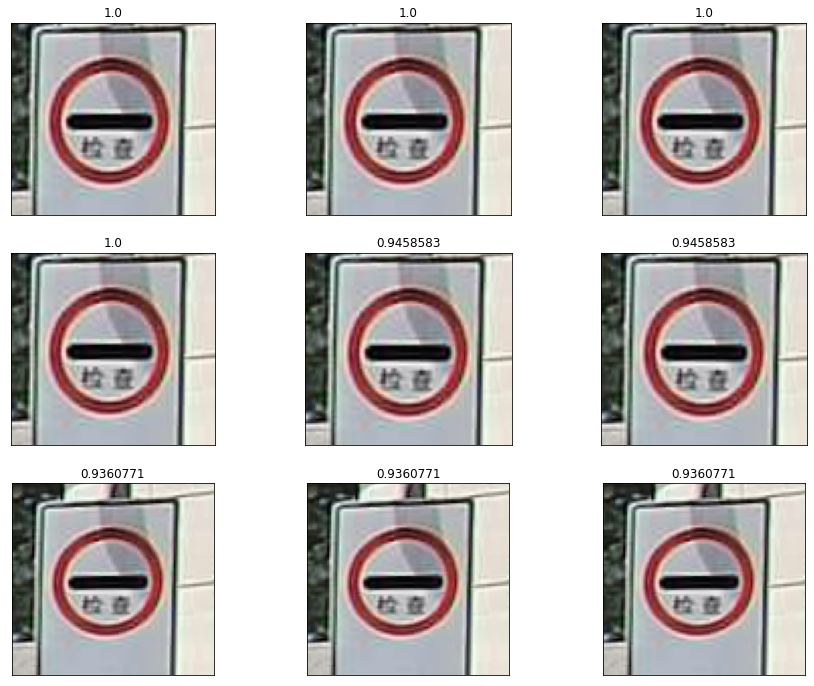

In [65]:
features = vehicle_features
prefix = 'data/vehicle'
feature_key = '057_1_0002.png'
top_k = 9

for t in types:
    feats = features[t]
    feature_value = feats[feature_key]
    similarities = []
    for k, v in feats.items():
        similarities.append((k, cos_sim(feature_value, v)))
    similarities = sorted(similarities, key=lambda item: item[1], reverse=True)
    plt.figure(figsize=(15, 12))
    m = 1
    for item in similarities[:top_k]:
        image = Image.open(os.path.join(prefix, item[0]))
        plt.subplot(3, 3, m)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(item[1]))
        m+=1
    break